# 1 - Perkenalan

Nama        : Yuzal Qushoyyi Wahyudi\
Batch       : RMT-033\
Data        : [Data Project](https://www.kaggle.com/datasets/virenbr11/pothole-and-plain-rode-images)\
Objektif    : Pada Project kali ini akan dilakukan Artificial Neural Network untuk menebak apakah suatu jalan itu berlubang atau tidak.

# 2 - Import Modul

> Import Modul yang akan digunakan.

In [1]:
# Import libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# 3 - Data Loading

> Load DATA

In [4]:
# Define path

main_path = 'D:\yuzal\Belajar\Hacktiv8\PHASE2\TUGAS\Pothole and Plain Road Images'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')

In [5]:
# Check how many data in `train_path` and `test_path`

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - Plain : 367
Total Data - Pothole : 357

Test Path
Total Data - Plain : 20
Total Data - Pothole : 20



In [6]:
# Function to visualize the first 5 images from each class

def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  Plain


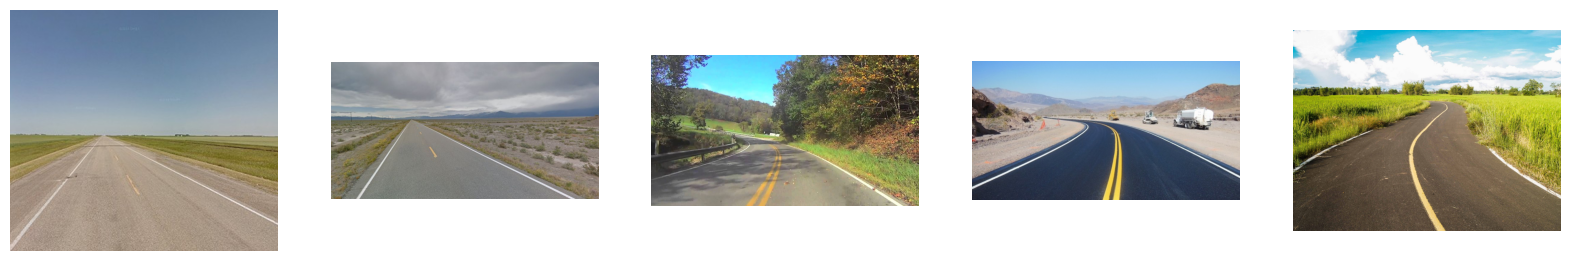

Class :  Pothole


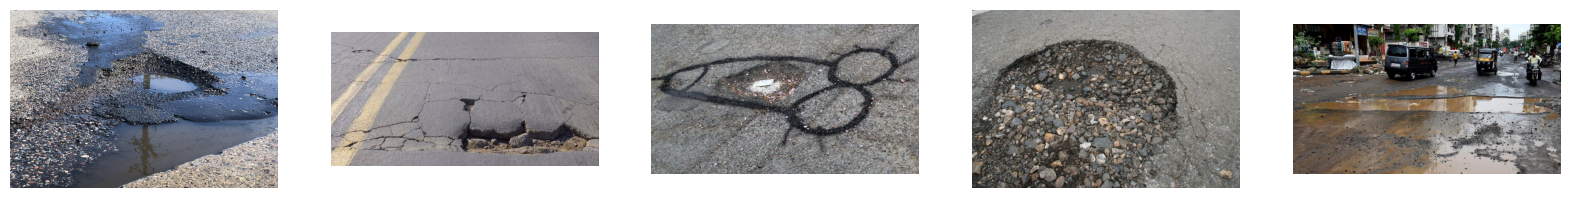

In [8]:
# Visualization of train_path

plot_images(train_path)

Class :  Plain


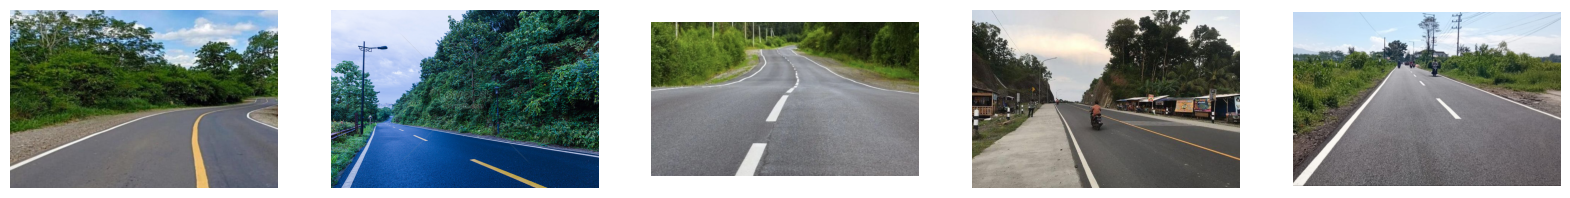

Class :  Pothole


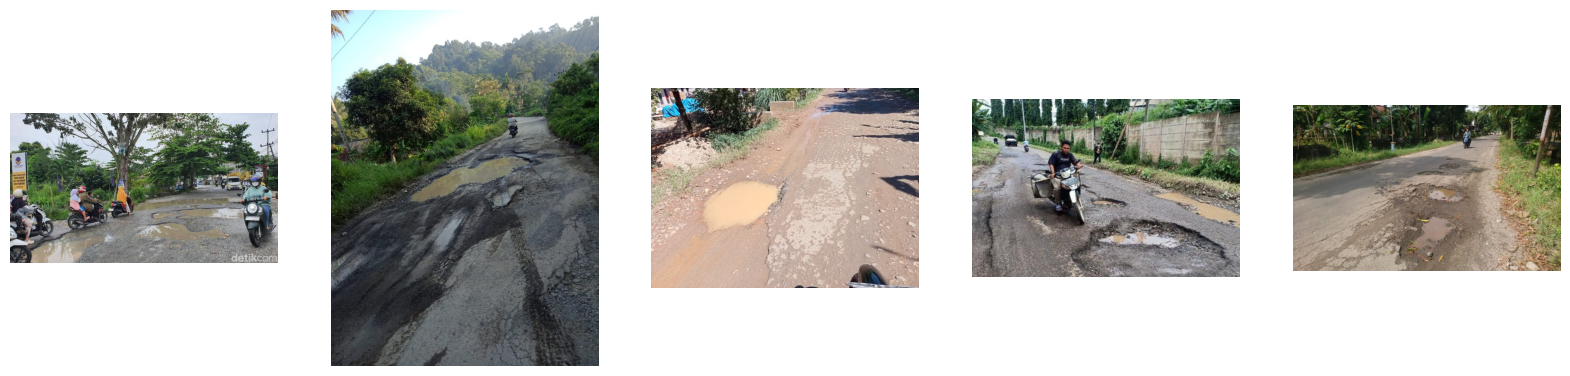

In [9]:
# Visualization of `test_path`

plot_images(test_path)

# 4 - Exploratory Data Analysis (EDA)

In [6]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(150,150),
                                              class_mode='binary',
                                              subset='training',
                                              batch_size=32,
                                              shuffle=True,
                                              seed=2)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(150,150),
                                            class_mode='binary',
                                            subset='validation',
                                            batch_size=32,
                                            shuffle=True,
                                            seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(150,150),
                                            class_mode='binary',
                                            batch_size=32,
                                            shuffle=False,
                                            seed=2)

Found 435 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


## 4.1 - Class

In [11]:
class_distribution = train_set.class_indices
print("Distribusi Kelas:", class_distribution)


Distribusi Kelas: {'Plain': 0, 'Pothole': 1}


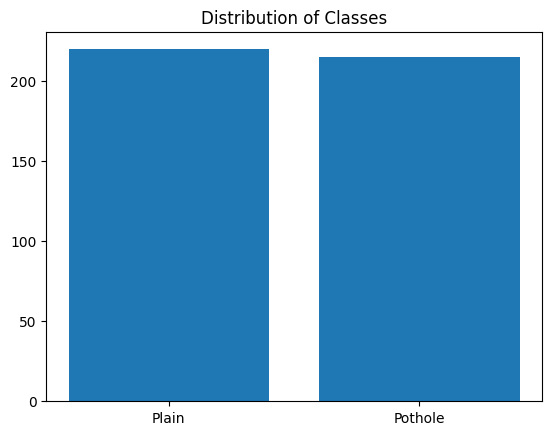

In [12]:
classes = train_set.class_indices
class_counts = train_set.classes
plt.bar(classes.keys(), np.bincount(class_counts))
plt.title('Distribution of Classes')
plt.show()

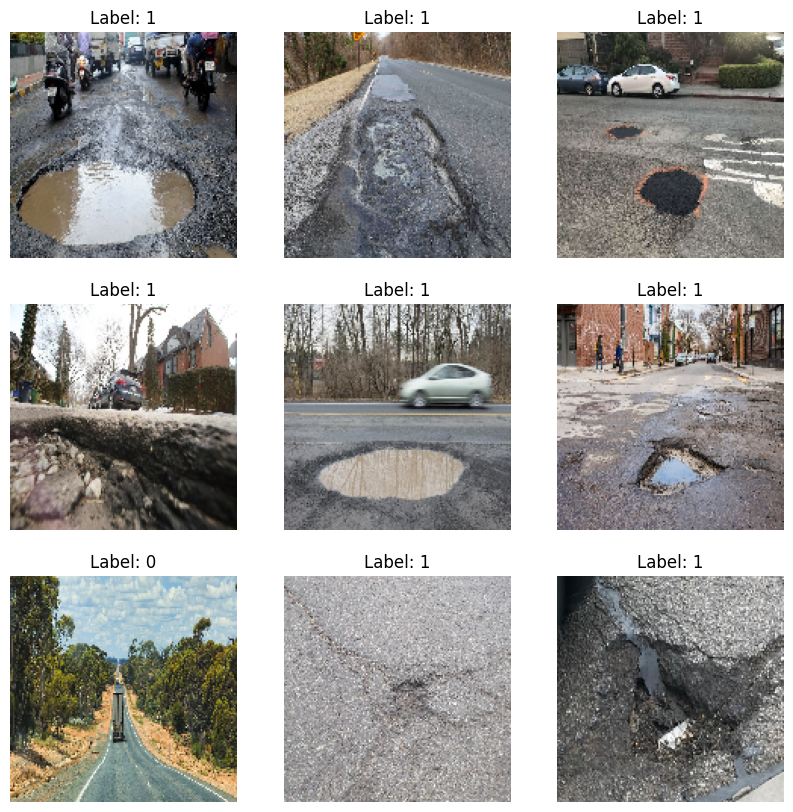

In [7]:
# Mendapatkan batch pertama dari train_set
images, labels = next(train_set)

# Menampilkan 9 gambar pertama
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'Label: {int(labels[i])}')
    plt.axis('off')
plt.show()


- Diketahui bahwa hanya terdapat 2 class pada data ini yaitu jalan mulus dan jalan berlubang.
- Rata-rata angle foto yang diambil kebanyak dari atas.

## 4.2 - RGB

In [8]:
# Function to load images and convert them to a dataframe
def load_images_to_df(path):
    data = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                img = Image.open(img_path).convert('RGB')
                img_np = np.array(img)
                r_mean = np.mean(img_np[:, :, 0])
                g_mean = np.mean(img_np[:, :, 1])
                b_mean = np.mean(img_np[:, :, 2])
                data.append([img_path, folder, r_mean, g_mean, b_mean])
    
    df = pd.DataFrame(data, columns=['image_path', 'label', 'r_mean', 'g_mean', 'b_mean'])
    return df

# Load images from train and test sets
train_df = load_images_to_df(train_path)
test_df = load_images_to_df(test_path)

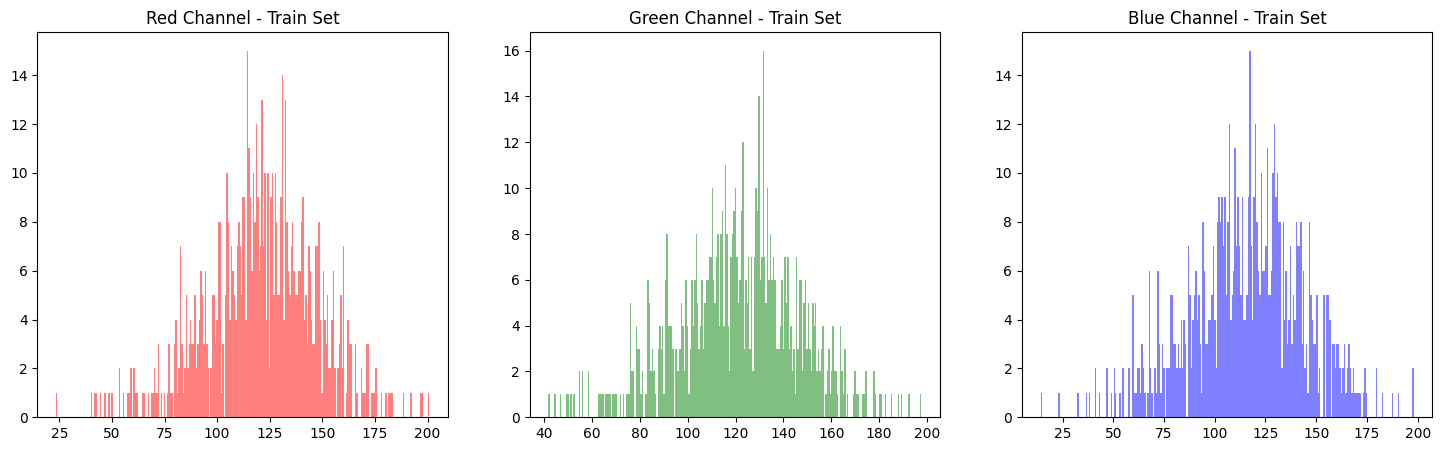

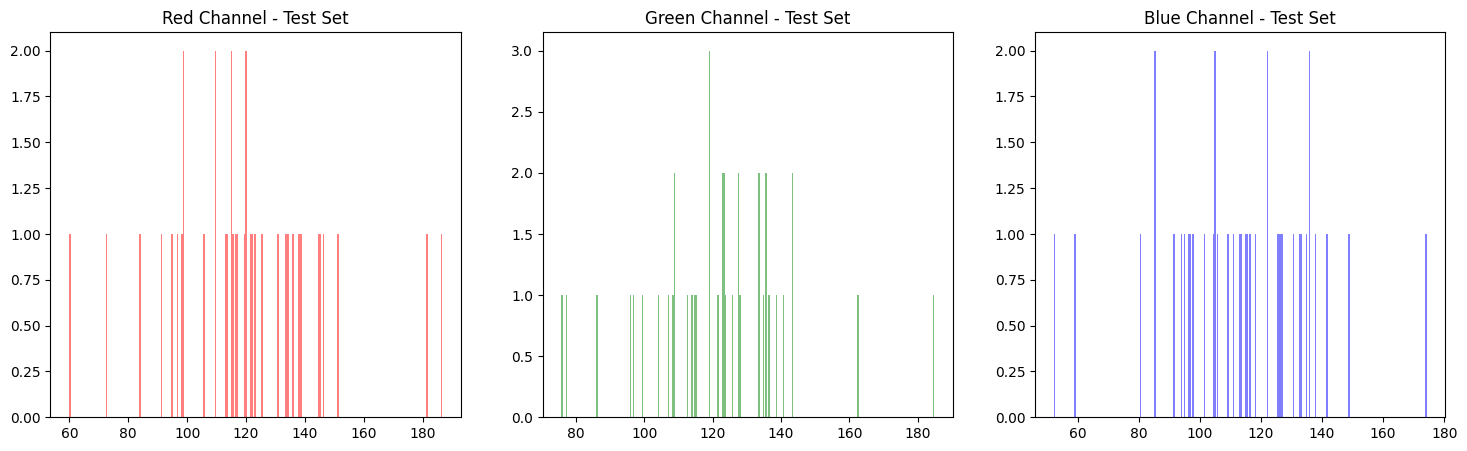

In [9]:
# Visualisasi distribusi warna
def plot_rgb_distribution(df, label):
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(df['r_mean'], bins=256, color='red', alpha=0.5)
    plt.title(f'Red Channel - {label}')

    plt.subplot(1, 3, 2)
    plt.hist(df['g_mean'], bins=256, color='green', alpha=0.5)
    plt.title(f'Green Channel - {label}')

    plt.subplot(1, 3, 3)
    plt.hist(df['b_mean'], bins=256, color='blue', alpha=0.5)
    plt.title(f'Blue Channel - {label}')
    
    plt.show()

# Plot distribusi untuk train set dan test set
plot_rgb_distribution(train_df, 'Train Set')
plot_rgb_distribution(test_df, 'Test Set')


- Pada data ini kebanyakan warna RGB pada data didominasi oleh warna hijau dikarenakan juga pada jalan terdapat banyak hutan.

# 5 - Feature Engineering

## 5.1 - Preprocessing

In [10]:
# Define hyperparameters

img_height= 150
img_width= 150
batch_size= 32

- Menggunakan pixel 150x150 dengan batch size 32

In [11]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                    rotation_range=20,
                                                                    zoom_range=0.05,
                                                                    width_shift_range=0.05,
                                                                    height_shift_range=0.05,
                                                                    shear_range=0.05,
                                                                    horizontal_flip=True,
                                                                    validation_split=0.4)

train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                      target_size=(img_height,img_width),
                                                      class_mode='binary',
                                                      subset='training',
                                                      batch_size=batch_size,
                                                      shuffle=False,
                                                      seed=2)

val_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='binary',
                                                    subset='validation',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=2)

test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='binary',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=2)

Found 435 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


- Dilakukan Data Augmentation pada data dengan menggunakan semua fiturnya yaitu zoom, rotation, width shift, height shift, shear range dan horizontal flip.
- Setelah dilakukan pembagian data terdapat 2 class dengan data train sebanyak 435 data validation sebanyak 288 dan data test sebanyak 40.

# 6 - CNN Training

## 6.1 - Model Definition

In [12]:
# Clear session

seed = 23
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

- Menggunakan seed 23.

In [13]:
# Create Sequential API model

model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(64, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(128, (3,3),activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dense(1, activation='sigmoid'))

# Compile
model_aug.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_aug.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

- Menggunakan 2 hidden layer dengan hidden layer pertama sebanyak 64 neuron dan hidden layer kedua sebanyak 128 neuron.
- Pada output layer digunakan activation sigmoid dikarenakan data yang digunakan bersifat binary.

## 6.2 - Model Training

In [16]:
%%time
# Train Model

history = model_aug.fit(train_set_aug, epochs=20, validation_data=val_set_aug, batch_size=batch_size)


Epoch 1/20
14/14 [==============================] - 14s 1s/step - loss: 0.6941 - accuracy: 0.5057 - val_loss: 0.6926 - val_accuracy: 0.5069
Epoch 2/20
14/14 [==============================] - 14s 985ms/step - loss: 0.6929 - accuracy: 0.5057 - val_loss: 0.6920 - val_accuracy: 0.5069
Epoch 3/20
14/14 [==============================] - 13s 976ms/step - loss: 1.3990 - accuracy: 0.4483 - val_loss: 3.9754 - val_accuracy: 0.5069
Epoch 4/20
14/14 [==============================] - 14s 1s/step - loss: 1.0658 - accuracy: 0.4874 - val_loss: 0.6790 - val_accuracy: 0.6806
Epoch 5/20
14/14 [==============================] - 15s 1s/step - loss: 0.8578 - accuracy: 0.5908 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 6/20
14/14 [==============================] - 13s 969ms/step - loss: 0.6933 - accuracy: 0.4943 - val_loss: 0.6932 - val_accuracy: 0.4931
Epoch 7/20
14/14 [==============================] - 13s 937ms/step - loss: 0.6933 - accuracy: 0.4943 - val_loss: 0.6931 - val_accuracy: 0.4931
Epoch 8/

## 6.3 - Model Evaluation

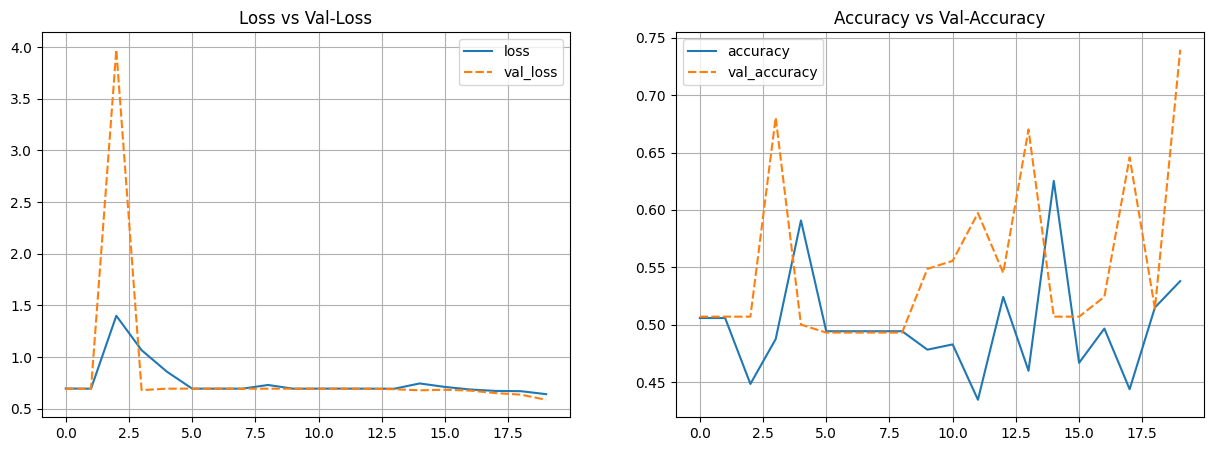

In [17]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

- Pada grafik Loss dan Val-loss didapatkan bahwa nilai dari kedua semakin mendekati nol maka data didapatkan cukup baik dan juga grafik dari kedua data ini saling berhimpitan menandakan bahwa data ini memiliki nilai loss yang baik.
- Pada grafik Accuracy dan Val-Accuracy didapatkan bahwa nilai dari kedua data ini semakin mendekati 1 yang dapat diartikan bahwa tebakan model semakil akurat hampir mendekati 100% dan grafik antara Accuracy dengan Val-Accuracy terlihat berhimpitan.

In [18]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model_aug.predict(test_set)

## Get class with maximum probability
y_pred_class_aug = (y_pred_prob_aug > 0.5).astype("int32").flatten()

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

2/2 [==============================] - 0s 29ms/step
              precision    recall  f1-score   support

       Plain       0.71      0.60      0.65        20
     Pothole       0.65      0.75      0.70        20

    accuracy                           0.68        40
   macro avg       0.68      0.68      0.67        40
weighted avg       0.68      0.68      0.67        40



In [19]:
# Check the performance of train-set

## Get the probability
y_pred_prob_aug = model_aug.predict(train_set_aug)

## Get class with maximum probability
y_pred_class_aug = (y_pred_prob_aug > 0.5).astype("int32").flatten()

## Display Classification Report
print(classification_report(train_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

14/14 [==============================] - 6s 417ms/step
              precision    recall  f1-score   support

       Plain       0.69      0.72      0.71       220
     Pothole       0.70      0.67      0.69       215

    accuracy                           0.70       435
   macro avg       0.70      0.70      0.70       435
weighted avg       0.70      0.70      0.70       435



- Hasil classification report antara test set dengan report test memiliki hasil yang overfitting dikarenakan model pada train mampu menebak dengan akurasi 88% sedangkan pada test mampu menebak dengan akurasi 70% maka dari itu model ini termasuk overfitting.

# 7 - CNN Improvement

## 7.1 - Model Definition

In [20]:
# Clear session

seed = 23
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# CNN Improvement

model_aug_improvement = Sequential()
model_aug_improvement.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model_aug_improvement.add(BatchNormalization())
model_aug_improvement.add(MaxPooling2D(2, 2))
model_aug_improvement.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_aug_improvement.add(BatchNormalization())
model_aug_improvement.add(MaxPooling2D(2, 2))
model_aug_improvement.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_aug_improvement.add(BatchNormalization())
model_aug_improvement.add(MaxPooling2D(2, 2))
model_aug_improvement.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_aug_improvement.add(BatchNormalization())
model_aug_improvement.add(MaxPooling2D(2, 2))
model_aug_improvement.add(Flatten())
model_aug_improvement.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_aug_improvement.add(BatchNormalization())
model_aug_improvement.add(Dropout(0.5))
model_aug_improvement.add(Dense(1, activation='sigmoid'))

# Compile
model_aug_improvement.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_aug_improvement.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                        

- Pada Model Improvement ini saya menambahkan 1 hidden layer dengan jumlah neuron sebanyak 256 dan juga saya menambahkan fungsi BatchNormalization dan Kernel_regularizer untuk dapat mengatasi overfitting yang berlebihan pada model sebelumnya.

## 7.2 - Model Training

In [21]:
# Menambahkan EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [22]:
# Menambahkan reduce learning

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [23]:
# Menambahkan Model Checkpoint

checkpoint_filepath = 'model.keras'

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',mode='max',save_best_only=True)

In [31]:
# Load Model 

model_aug_improvement = tf.keras.models.load_model(
    'D:\yuzal\Belajar\Hacktiv8\PHASE2\TUGAS\p2-ftds033-rmt-g7-yuzalle\deployment\model.keras', custom_objects=None, compile=True
)

In [32]:
%%time
# Train Model

history_improvement = model_aug_improvement.fit(
    train_set_aug,
    validation_data=val_set_aug,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, model_checkpoint_callback]
)

Epoch 1/50
14/14 [==============================] - 18s 1s/step - loss: 1.9586 - accuracy: 0.4667 - val_loss: 1.4752 - val_accuracy: 0.5590 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 17s 1s/step - loss: 1.5713 - accuracy: 0.4920 - val_loss: 1.7156 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 17s 1s/step - loss: 1.5814 - accuracy: 0.4897 - val_loss: 1.5520 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 17s 1s/step - loss: 1.5074 - accuracy: 0.5011 - val_loss: 1.4897 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 17s 1s/step - loss: 1.5100 - accuracy: 0.5034 - val_loss: 1.3704 - val_accuracy: 0.6007 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 16s 1s/step - loss: 1.4699 - accuracy: 0.5057 - val_loss: 1.3879 - val_accuracy: 0.4618 - lr: 0.0010
Epoch 7/50
14/14 [==============================] - 16s 1s/step - loss: 1.4148 - a

## 7.3 - Model Evaluation

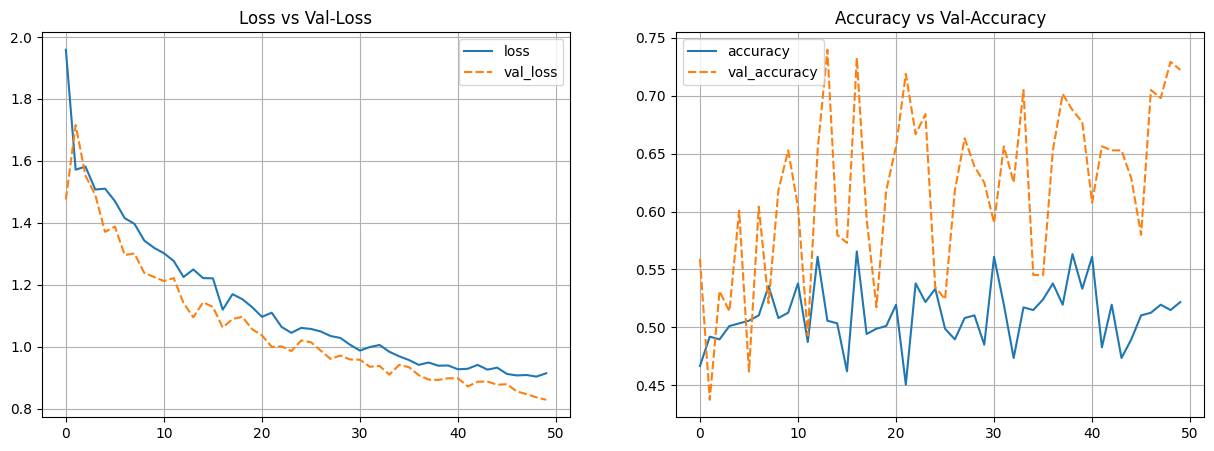

In [33]:
# Plot training results

history_df_improvement = pd.DataFrame(history_improvement.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df_improvement[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df_improvement[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [34]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug_improvement = model_aug_improvement.predict(test_set)

## Get class with maximum probability
y_pred_class_aug_improvement = (y_pred_prob_aug_improvement > 0.5).astype("int32").flatten()

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug_improvement, target_names=np.array(list(train_set_aug.class_indices.keys()))))

2/2 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

       Plain       0.64      0.90      0.75        20
     Pothole       0.83      0.50      0.62        20

    accuracy                           0.70        40
   macro avg       0.74      0.70      0.69        40
weighted avg       0.74      0.70      0.69        40



In [35]:
# Check the performance of train-set

## Get the probability
y_pred_prob_aug_improvement = model_aug_improvement.predict(train_set_aug)

## Get class with maximum probability
y_pred_class_aug_improvement = (y_pred_prob_aug_improvement > 0.5).astype("int32").flatten()

## Display Classification Report
print(classification_report(train_set_aug.classes, y_pred_class_aug_improvement, target_names=np.array(list(train_set_aug.class_indices.keys()))))

14/14 [==============================] - 9s 675ms/step
              precision    recall  f1-score   support

       Plain       0.70      0.87      0.78       220
     Pothole       0.83      0.62      0.71       215

    accuracy                           0.75       435
   macro avg       0.76      0.75      0.74       435
weighted avg       0.76      0.75      0.74       435



- Setelah dilakukan improvement dengan menambahkan BatchNormalization dan Kerne_regulizer didapatkan bahwa data yang dihasilkan menjadi memburuk dan membuat data overfitting dengan nilai akurasi untuk test sebesar 45% dan train sebesar 63%. Maka dari itu saya mengambil model sebelum dilakukannya improvement.

# 8 - Model Saving

In [23]:
#Save Model Terbaik
model_aug.save("model.keras")

# 9 - Model Inference

In [28]:
# Load Model 

model_best = tf.keras.models.load_model(
    'D:\yuzal\Belajar\Hacktiv8\PHASE2\TUGAS\p2-ftds033-rmt-g7-yuzalle\model.keras', custom_objects=None, compile=True
)

In [30]:
# Check Model

model_best.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,443,845 (77.99 MB)

 Trainable params: 6,813,953 (25.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 13,627,908 (51.99 MB)

In [34]:
# Test Jalan Rusak

img = image.load_img('D:\yuzal\Belajar\Hacktiv8\PHASE2\TUGAS\p2-ftds033-rmt-g7-yuzalle\jlnrsk.jpg', target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

prediction = model_best.predict(img_array)
print(prediction)
if prediction > 0.5:
    print("Plothole")
else:
    print("Plain")
# print('Prediction:', prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.51485103]]
Plothole


In [35]:
# Test Jalan Bagus

img = image.load_img('D:\yuzal\Belajar\Hacktiv8\PHASE2\TUGAS\p2-ftds033-rmt-g7-yuzalle\jlnbgs.jpg', target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

prediction = model_best.predict(img_array)
print(prediction)
if prediction > 0.5:
    print("Plothole")
else:
    print("Plain")
# print('Prediction:', prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.44568896]]
Plain


# 10. Kesimpulan

- Pada model CNN Training sebelum improvement akurasi yang didapatkan cukup baik dengan rata-rata hasil akurasi mencapai 70% dibandingkan CNN Improvement, maka dari itu model awal akan diambil.
- Dalam sisi bisnis model ini sudah cukup baik untuk menebak mana saja jalan yang berlubang dan juga jalan yang lurus dikarenakan akurasi yang sudah mencapai 70% dapat juga dilihat dalam model inference, model dapat menebak dengan cukup baik pada dummy data.
- Untuk Improvement selanjutnya dapat dilakukan transfer learning untuk mendapatkan hasil yang lebih baik, namun jika ingin mengubah secara manual dapat dilakukan penambahan atau pengurangan hidden layer dan juga neuron sehingga data yang didapatkan lebih baik.